In [1]:
# Import Distributions to generate random numbers W matrix of the RBM
using Distributions
using MNIST
using BenchmarkTools
using PyPlot

In [2]:
function generate_M(W, n_columns)

    n_hid = size(W)[1]
    n_vis = size(W)[2]
    costat = Int(sqrt(n_vis))    
    n_rows = Int(round(n_hid/n_columns))   

    print("\ncostat: ",costat,
          " \nn_rows: ", n_rows,
          "\nn_cols: ", n_columns)
    
    M = zeros(costat * n_rows, costat * n_columns)
    
    n_im = 1
    for r in 1:costat:size(M)[1]
        for c in 1:costat:size(M)[2]
            M[r:r+costat-1, c:c+costat-1] = reshape(W[n_im,:],costat,costat)
            n_im +=1
        end
    end
    return M
end

generate_M (generic function with 1 method)

In [3]:
#sample([1,1,1], Distributions.Gaussian(1))

In [4]:
type RBM{T <: Real}
    n_vis::Int
    n_hid::Int
    W::Matrix{T}         
    vis_bias::Vector{T}     
    hid_bias::Vector{T}   
    trained::Bool
end

function Base.show{T}(io::IO, rbm::RBM{T})
    n_vis = size(rbm.vis_bias, 1)
    n_hid = size(rbm.hid_bias, 1)
    trained = rbm.trained
    print(io, "RBM{$T}(n_vis=$n_vis, n_hid=$n_hid, trained=$trained)")
end

In [5]:
function sigmoid(x::Float32)
    return 1/(1 + exp(-x))
end

sigmoid (generic function with 1 method)

In [6]:
function initialize_RBM(n_vis, n_hid, sigma, T)
    
    return RBM{T}( n_vis,                                 # num visible units 
                   n_hid,                                 # num hidden unnits
                   rand(Normal(0,sigma), n_hid, n_vis),  # weight matrix
                   zeros(n_vis),                          # visible vector  
                   zeros(n_hid),                          # Hidden vector
                   false)                                 # trained
end

initialize_RBM (generic function with 1 method)

In [7]:
function generate_M(W, n_columns)

    n_hid = size(W)[1]
    n_vis = size(W)[2]
    costat = Int(sqrt(n_vis))    
    n_rows = Int(round(n_hid/n_columns) )   

    print("\ncostat: ", costat,
          "\nn_rows: ", n_rows,
          "\nn_cols: ", n_columns)
    
    M = zeros(costat * n_rows, costat * n_columns)
    
    n_im = 1
    for r in 1:costat:size(M)[1]
        for c in 1:costat:size(M)[2]
            M[r:r+costat-1, c:c+costat-1] = reshape(W[n_im,:],costat,costat)
            n_im +=1
        end
    end
    return M
end

generate_M (generic function with 1 method)

In [8]:
rbm = initialize_RBM(784, 100, 0.01, Float32)

RBM{Float32}(n_vis=784, n_hid=100, trained=false)

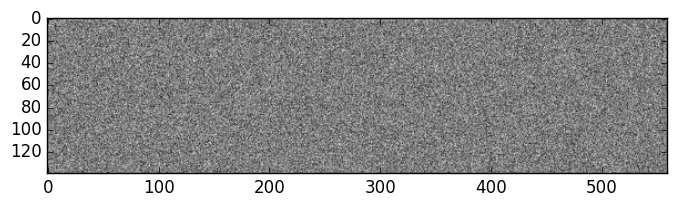


costat: 28
n_rows: 5
n_cols: 20

PyObject <matplotlib.image.AxesImage object at 0x7f61fa0d9b10>

In [9]:
M = generate_M(rbm.W, 20)
PyPlot.imshow(M,"gray")

In [42]:
X_train, y_train = MNIST.traindata()
X_test, y_test = MNIST.testdata()


T = Float32
X_train = Array{T}( (X_train - minimum(X_train))/(maximum(X_train) - minimum(X_train)) )
y_train = Array{T}(y_train)
X_test = Array{T}(X_test - minimum(X_test))/(maximum(X_test) - minimum(X_test)) 
y_test = Array{T}(y_test);

In [43]:
minimum(X_train), maximum(X_train)

(0.0f0,1.0f0)

In [45]:
function vec_contrastive_divergence_K(Xbatch, rbm, K::Integer, lr::Real, T)
    
    Xneg = copy(Xbatch)
    batch_size = size(Xbatch)[2]
    
    local Hneg::Array{T} = zeros(rbm.n_hid, batch_size)
    local Xneg::Array{T} = zeros(rbm.n_vis, batch_size)
    local Ehp::Array{T} = zeros(rbm.n_hid, batch_size)
    local Ehn::Array{T} = zeros(rbm.n_hid, batch_size)
    
    for k in 1:K
        Hneg .= sigmoid.(rbm.W * Xneg .+ rbm.hid_bias) .> rand()
        Xneg .= sigmoid.(rbm.W' * Hneg  .+ rbm.vis_bias) .> rand()
    end
       
    Ehp .= sigmoid.(rbm.W * Xbatch .+ rbm.hid_bias)
    Ehn .= sigmoid.(rbm.W * Xneg .+ rbm.hid_bias)
    
    rbm.W .+= lr.*( Ehp * Xbatch' .-  Ehn *  Xneg') ./ batch_size;
    rbm.vis_bias .+= sum(lr .* (Xbatch .- Xneg), 2)[:]./ batch_size;
    rbm.hid_bias .+= sum(lr .* (Ehp .- Ehn), 2)[:] ./ batch_size;
end

vec_contrastive_divergence_K (generic function with 1 method)

In [46]:
X_batch = X_train[:,1:25]
@benchmark vec_contrastive_divergence_K(X_batch, rbm, 1, 0.01, T)

BenchmarkTools.Trial: 
  memory estimate:  2.68 MiB
  allocs estimate:  326
  --------------
  minimum time:     1.838 ms (0.00% GC)
  median time:      2.136 ms (0.00% GC)
  mean time:        2.790 ms (5.54% GC)
  maximum time:     118.727 ms (95.34% GC)
  --------------
  samples:          1773
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

In [16]:
function vec_fit_CDK(X, rbm, batch_size::Integer,  n_epochs::Integer, K::Integer, lr::Real,T)
        
    n_samples = size(X)[2]
    indicies = [x:min(x + batch_size-1, n_samples) for x in 1:batch_size:n_samples]
    mb = 1
    for epoch in 1:n_epochs
        for minibatch_ind in indicies
            vec_contrastive_divergence_K((@view X[:, minibatch_ind]), rbm, K, lr,T)
        end
    end
    rbm.trained = true
end

vec_fit_CDK (generic function with 1 method)

In [17]:
n_epochs = 1
batch_size = 500
K = 1
lr = 0.01

@benchmark vec_fit_CDK(X_train, rbm, batch_size,  n_epochs, K, lr, T)

BenchmarkTools.Trial: 
  memory estimate:  2.20 GiB
  allocs estimate:  81241
  --------------
  minimum time:     3.108 s (6.22% GC)
  median time:      3.179 s (4.77% GC)
  mean time:        3.179 s (4.77% GC)
  maximum time:     3.250 s (3.39% GC)
  --------------
  samples:          2
  evals/sample:     1
  time tolerance:   5.00%
  memory tolerance: 1.00%

## Train model several epochs 

Plot the weights after training

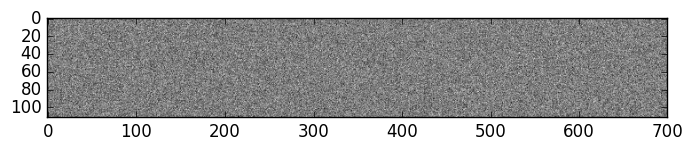


costat: 28
n_rows: 4
n_cols: 25

PyObject <matplotlib.image.AxesImage object at 0x7f61e4906a10>

In [91]:
rbm = initialize_RBM(784, 100, 0.01, Float32)
M = generate_M(rbm.W,25);
PyPlot.imshow(M,"gray")

In [92]:
vec_contrastive_divergence_K(X_train[:,1:500], rbm, 1, 0.05, T);

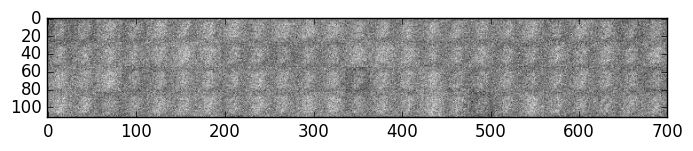


costat: 28
n_rows: 4
n_cols: 25

PyObject <matplotlib.image.AxesImage object at 0x7f61e48364d0>

In [93]:
M = generate_M(rbm.W,25);
PyPlot.imshow(M,"gray")

In [94]:
n_epochs = 200
batch_size = 200
K = 1
lr = 0.001

vec_fit_CDK(X_train, rbm, batch_size,  n_epochs, K, lr, T)

true

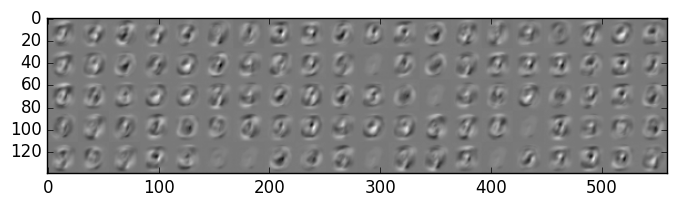


costat: 28
n_rows: 5
n_cols: 20

PyObject <matplotlib.image.AxesImage object at 0x7f61e4347a50>

In [101]:
M = generate_M(rbm.W, 20);
PyPlot.imshow(M,"gray")

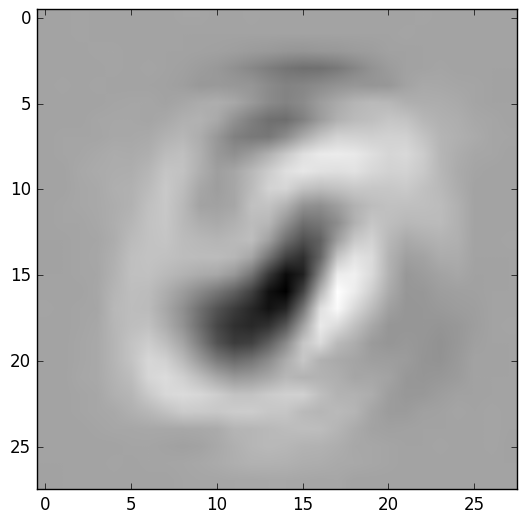

PyObject <matplotlib.image.AxesImage object at 0x7f61e401a510>

In [105]:
PyPlot.imshow(reshape(rbm.W[10,:],28,28),"gray")